# Vet a Known Exoplanet
This notebook pulls the parameters and light curve of a known exoplanet, WASP-18 b. It then runs three vetters on on that TCE and light curve. It is used as an example of how to run the vetters in the exovetter package.

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.model import create_box_model_for_tce
from exovetter.tce import Tce
from exovetter import vetters as vet

In [2]:
%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
header={}

## Create a TCE using exo.MAST requests.
Since we are vetting a known exoplanet, we pull down the information about the exoplanet transit from exo.mast's API. We then create a TCE for vetting. A TCE is an object that contains the transit ephemeris and basic parameters that usually come out of a transit search pipeline (period, epoch, snr, depth).

In [3]:
planet_name = "WASP-18 b"

url = planeturl + "/identifiers/"
myparams = {"name":planet_name}
r = requests.get(url = url, params = myparams, headers = header)
planet_names = r.json()
ticid = planet_names['tessID']
tceid = planet_names['tessTCE']

In [4]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()
nexsci_prop = planet_prop[1]  #Second one returned

Catalog 2: nexsci


In [5]:
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Get a lightkurve for this object
We use the lightkurve package to pull down sector 3 data for TESS data on this object. We then flatten that data to remove any remaining instrumental systematics.

In [6]:
lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
lc = lcf.SAP_FLUX.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

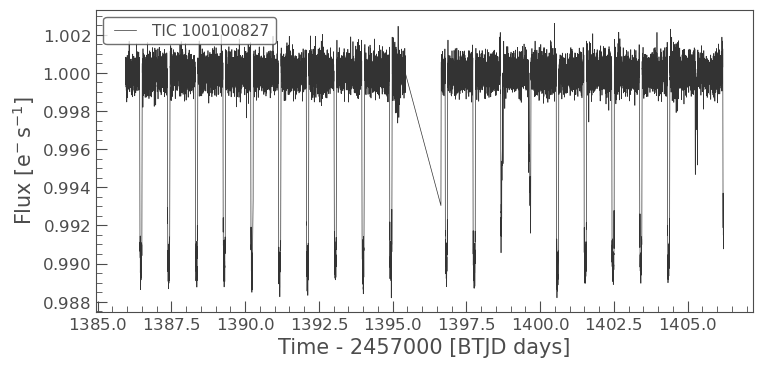

In [7]:
flat.plot()

In [8]:
lpp = vet.Lpp(lc_name="flux")
_ = lpp.run(tce,flat)

/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/lpp.py:369: UserWarning: Removing median. The supplied light curve isnot normalized to zero.
  warnings.warn("Removing median. The supplied light curve is"


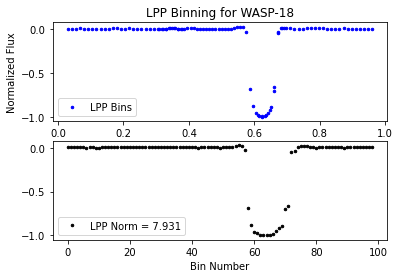

In [9]:
lpp.plot()

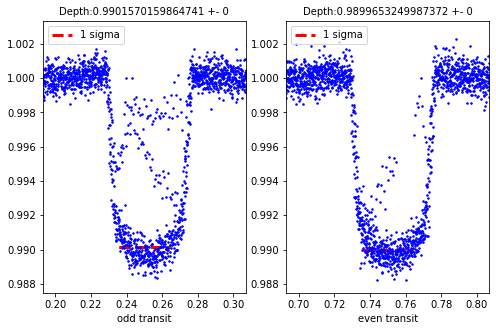

In [10]:
oe = vet.OddEven()
_ = oe.run(tce,flat)
oe.plot()

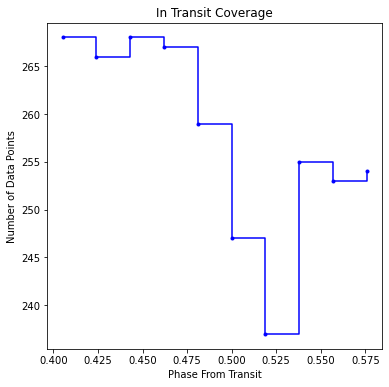

In [11]:
tcover = vet.TransitPhaseCoverage()
_ = tcover.run(tce,flat)
tcover.plot()

In [12]:
tcover.lc_name

'flux'

In [13]:
#Each Vetter can be returned as a dictionary
tcover.__dict__

{'lc_name': 'flux',
 'time': array([1385.95220258, 1385.95359146, 1385.95498034, ..., 1406.21438965,
        1406.2157785 , 1406.21716735]),
 'flux': array([1.00080132, 0.99940657, 1.00069271, ..., 0.99180555, 0.99076658,
        0.99198054]),
 'tp_cover': 1.0,
 'hist': array([268, 266, 268, 267, 259, 247, 237, 255, 253, 254]),
 'bins': array([0.40510391, 0.42408312, 0.44306234, 0.46204156, 0.48102078,
        0.5       , 0.51897922, 0.53795844, 0.55693766, 0.57591688,
        0.59489609])}

In [14]:
#Exovetter uses the lightcurve time_format for units on the times.
lc.time_format

'btjd'